In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
import io

# -----------------------------
# 1. Paths & parameters
# -----------------------------
geojson_path = "/Users/luana/Downloads/Grid_AllWetlands_Cottonwood.geojson"
data_path    = "/Users/luana/Downloads/GSW_Data_w_pred.csv"

lat_col  = "LAT"
lon_col  = "LONG"
pred_col = "predictions"  # log(methane)
date_col = "DATE"

round_decimals = 5

# OPTIONAL: skip dates to speed up further (1 = use all)
date_step = 2   # change to 2, 3, ... if needed

# -----------------------------
# 2. Load data
# -----------------------------
gdf = gpd.read_file(geojson_path)
df  = pd.read_csv(data_path)

df[date_col] = pd.to_datetime(df[date_col])

# -----------------------------
# 3. Prepare rounded LAT/LONG & key once
# -----------------------------
df["lat_round"] = df[lat_col].round(round_decimals)
df["lon_round"] = df[lon_col].round(round_decimals)

if lat_col in gdf.columns and lon_col in gdf.columns:
    gdf["lat_round"] = gdf[lat_col].round(round_decimals)
    gdf["lon_round"] = gdf[lon_col].round(round_decimals)
else:
    gdf = gdf.to_crs(epsg=4326)  # WGS84
    gdf["lat_round"] = gdf.geometry.centroid.y.round(round_decimals)
    gdf["lon_round"] = gdf.geometry.centroid.x.round(round_decimals)

# Build a key so we don't need a MultiIndex
gdf["cell_key"] = list(zip(gdf["lat_round"], gdf["lon_round"]))
df["cell_key"]  = list(zip(df["lat_round"], df["lon_round"]))

# OPTIONAL SPEEDUP: simplify geometries slightly if very detailed
# gdf["geometry"] = gdf.geometry.simplify(0.0001, preserve_topology=True)

base_gdf = gdf.copy()

# -----------------------------
# 4. Unique dates & color scale
# -----------------------------
# One frame per unique date (this also fixes the "every row = date" issue)
all_dates = np.sort(df[date_col].dropna().unique())
all_dates = all_dates[::date_step]   # skip dates if desired

vmin = df[pred_col].min()
vmax = df[pred_col].max()

# -----------------------------
# 5. Build frames
# -----------------------------
frames = []

for d in all_dates:
    df_day = df[df[date_col] == d]
    if df_day.empty:
        continue

    # If multiple rows per cell+date, aggregate (mean here, change if needed)
    s = (
        df_day
        .groupby("cell_key")[pred_col]
        .mean())

    # Copy base grid and map predictions by cell_key
    plot_gdf = base_gdf.copy()
    plot_gdf[pred_col] = plot_gdf["cell_key"].map(s)

    # Keep only features with data for this date
    plot_gdf = plot_gdf.dropna(subset=[pred_col])
    if plot_gdf.empty:
        continue

    fig, ax = plt.subplots(figsize=(10, 8))

    plot_gdf.plot(
        column=pred_col,
        ax=ax,
        legend=True,
        edgecolor="none",
        vmin=vmin,
        vmax=vmax,
        legend_kwds={
            "shrink": 0.7,
            "label": "log(CH₄)",},)

    date_str = pd.to_datetime(d).strftime("%Y-%m-%d")
    fig.suptitle(
        f"Per-pixel Methane Emission Predictions Over Time\nDate: {date_str}",
        fontsize=14,
        y=0.85,
    )

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.tight_layout()

    # Slightly lower DPI for speed
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", dpi=100)
    buf.seek(0)
    image = imageio.imread(buf)
    buf.close()

    frames.append(image)
    plt.tight_layout()
    plt.close(fig)

# -----------------------------
# 6. Save GIF
# -----------------------------
output_gif = "/Users/luana/Downloads/methane_predictions_over_time.gif"

frame_duration = 1.5  # 1.5 seconds per frame
durations = [frame_duration] * len(frames)

imageio.mimsave(output_gif, frames, duration=durations, loop=0) 

# Time Series of Predicted Methane Emissions

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Paths & parameters
# -----------------------------
geojson_path = "/Users/luana/Downloads/Grid_AllWetlands_Cottonwood.geojson"
data_path    = "/Users/luana/Downloads/GSW_Data_w_pred.csv"

lat_col  = "LAT"
lon_col  = "LONG"
pred_col = "predictions"  # log(methane)
date_col = "DATE"

round_decimals = 5

# OPTIONAL: downsample dates when plotting (1 = use all)
date_step = 2   # use every 2nd point when plotting

wetland_col = "Wetland_ID"

# Wetland plotting order (biggest → smallest)
wetland_order = [
    "T4", "T5", "T7", "T6", "T2", "T8",
    "P3", "T3", "T1", "T9", "P8", "P6",
    "P7", "P4", "P2", "P1"]

# -----------------------------
# 2. Load data
# -----------------------------
gdf = gpd.read_file(geojson_path)
df  = pd.read_csv(data_path)

df[date_col] = pd.to_datetime(df[date_col])

# -----------------------------
# 3. Convert from log to linear methane
# -----------------------------
# Assuming predictions are natural log of methane
df["methane_linear"] = np.exp(df[pred_col])

# If your model outputs log10 instead, use this instead:
# df["methane_linear"] = np.power(10, df[pred_col])

# -----------------------------
# 4. Merge geometry wetland IDs with time series
# -----------------------------
merged_ts = gdf[[lat_col, lon_col, wetland_col]].merge(
    df[[date_col, lat_col, lon_col, "methane_linear"]],
    on=[lat_col, lon_col],
    how="left")

# Drop rows without methane or wetland id
merged_ts = merged_ts.dropna(subset=["methane_linear", wetland_col])

# -----------------------------
# 5. Sum *linear* methane per wetland per date
# -----------------------------
wetland_daily = (
    merged_ts
    .groupby([date_col, wetland_col], as_index=False)["methane_linear"]
    .sum()
    .rename(columns={"methane_linear": "sum_methane_linear"}))

# -----------------------------
# 6. Convert summed methane back to log for plotting
# -----------------------------
wetland_daily["sum_methane_log"] = np.log(wetland_daily["sum_methane_linear"])

# If original was log10, use:
# wetland_daily["sum_methane_log"] = np.log10(wetland_daily["sum_methane_linear"])

# -----------------------------
# 7. Line plot with custom palette & order
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Use a discrete colormap with enough distinct colors
cmap = plt.cm.get_cmap("magma", len(wetland_order))

# Plot wetlands in the requested order
for idx, wid in enumerate(wetland_order):
    sub = wetland_daily[wetland_daily[wetland_col] == wid].copy()
    if sub.empty:
        continue

    sub = sub.sort_values(date_col)
    sub = sub.iloc[::date_step]  # downsample dates if desired

    ax.plot(
        sub[date_col],
        sub["sum_methane_log"],
        label=str(wid),
        alpha=0.9,
        color=cmap(idx)
    )

# If there are wetlands not in the list, plot them afterwards with leftover colors
other_wids = sorted(set(wetland_daily[wetland_col]) - set(wetland_order))
for j, wid in enumerate(other_wids, start=len(wetland_order)):
    sub = wetland_daily[wetland_daily[wetland_col] == wid].copy()
    if sub.empty:
        continue

    sub = sub.sort_values(date_col)
    sub = sub.iloc[::date_step]

    ax.plot(
        sub[date_col],
        sub["sum_methane_log"],
        label=str(wid),
        alpha=0.9,
        color=cmap(j % cmap.N)  # wrap if more than colormap size
)

ax.set_title("Log of Summed Methane Predictions per Wetland Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("log(Sum of CH₄)")

ax.legend(title="Wetland ID", bbox_to_anchor=(1, 1), loc="upper left")

plt.tight_layout()
plt.show()


# Center vs Margin Pixels

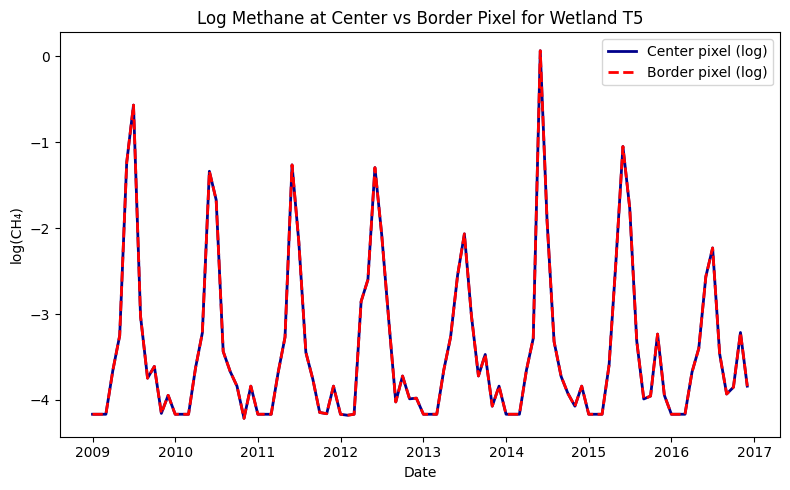

In [34]:
import numpy as np
import geopandas as gpd
import pandas as pd

# -----------------------------
# 1. Paths & parameters
# -----------------------------
geojson_path = "/Users/lauralayton/Downloads/output/Cottonwood/Grid_AllWetlands_Cottonwood.geojson"
data_path    = "/Users/lauralayton/Downloads/GSW_Data_w_pred.csv"

lat_col  = "LAT"
lon_col  = "LONG"
pred_col = "predictions"  # log(methane)
date_col = "DATE"

# round_decimals = 5

# OPTIONAL: downsample dates when plotting (1 = use all)
date_step = 2   # use every 2nd point when plotting

wetland_col = "Wetland_ID"

# Wetland plotting order (biggest → smallest)
wetland_order = [
    "T4", "T5", "T7", "T6", "T2", "T8",
    "P3", "T3", "T1", "T9", "P8", "P6",
    "P7", "P4", "P2", "P1"]

# -----------------------------
# 2. Load data
# # -----------------------------
gdf = gpd.read_file(geojson_path)
df  = pd.read_csv(data_path)

df[date_col] = pd.to_datetime(df[date_col])

# Make sure DATE is datetime
df[date_col] = pd.to_datetime(df[date_col])

# --- Work in a projected CRS for centroids & distances ---

# If your file has a geographic CRS (e.g. EPSG:4326), reproject to a local UTM-like CRS
# This automatically picks a suitable UTM based on the data extent
if gdf.crs is None:
    # If you know the CRS of the shapefile, set it here instead of guessing
    # Example if it's WGS84:
    gdf = gdf.set_crs(epsg=4326)

if gdf.crs.is_geographic:
    gdf_proj = gdf.to_crs(gdf.estimate_utm_crs())
else:
    gdf_proj = gdf.copy()

# Centroids in projected coordinates (meters)
gdf["cx"] = gdf_proj.geometry.centroid.x
gdf["cy"] = gdf_proj.geometry.centroid.y

# Wetland-level centroid (mean of pixel centroids)
wet_centroids = (
    gdf
    .groupby(wetland_col)[["cx", "cy"]]
    .mean()
    .rename(columns={"cx": "wet_cx", "cy": "wet_cy"})
)

# Attach wetland centroids back to each pixel
gdf = gdf.merge(wet_centroids, on=wetland_col)

# Distance of each pixel from the wetland centroid (now in projected units, e.g. meters)
gdf["dist_center"] = np.sqrt(
    (gdf["cx"] - gdf["wet_cx"])**2 +
    (gdf["cy"] - gdf["wet_cy"])**2
)

# For each wetland, get index of the closest (middle) and farthest (border) pixel
idx_center = gdf.groupby(wetland_col)["dist_center"].idxmin()
idx_border = gdf.groupby(wetland_col)["dist_center"].idxmax()

center_pixels = gdf.loc[idx_center, [wetland_col, lat_col, lon_col]].reset_index(drop=True)
border_pixels = gdf.loc[idx_border, [wetland_col, lat_col, lon_col]].reset_index(drop=True)

center_pixels = center_pixels.rename(columns={lat_col: "center_lat", lon_col: "center_lon"})
border_pixels = border_pixels.rename(columns={lat_col: "border_lat", lon_col: "border_lon"})

# ----- Center pixel time series -----
center_ts = df.merge(
    center_pixels.rename(columns={"center_lat": lat_col, "center_lon": lon_col}),
    on=[lat_col, lon_col, wetland_col],
    how="inner")

center_ts = center_ts[[date_col, wetland_col, pred_col]].rename(
    columns={pred_col: "log_center"}
)

# ----- Border pixel time series -----
border_ts = df.merge(
    border_pixels.rename(columns={"border_lat": lat_col, "border_lon": lon_col}),
    on=[lat_col, lon_col, wetland_col],
    how="inner")

border_ts = border_ts[[date_col, wetland_col, pred_col]].rename(
    columns={pred_col: "log_border"})

# Align center and border by (DATE, Wetland_ID)
center_border = center_ts.merge(
    border_ts,
    on=[date_col, wetland_col],
    how="inner"
)

# -----------------------------
# Stay in log units
# -----------------------------

# Log of the ratio center/border (optional but interpretable)
# log_ratio = log(center) - log(border) = log(center / border)
center_border["log_ratio_center_border"] = (
    center_border["log_center"] - center_border["log_border"]
)

# -----------------------------
# Plot: center vs border (log units)
# -----------------------------
import matplotlib.pyplot as plt

wet_id = "T5"  # change to any Wetland_ID you care about

sub = (
    center_border[center_border[wetland_col] == wet_id]
    .sort_values(date_col))

fig, ax = plt.subplots(figsize=(8, 5))

# Plot log methane values for center and border
ax.plot(sub[date_col], sub["log_center"], label="Center pixel (log)", linewidth=2, color='darkblue')
ax.plot(sub[date_col], sub["log_border"], label="Border pixel (log)", linewidth=2, linestyle="--", color='red')

ax.set_title(f"Log Methane at Center vs Border Pixel for Wetland {wet_id}")
ax.set_xlabel("Date")
ax.set_ylabel("log(CH₄)")  # natural log of methane

ax.legend()
plt.tight_layout()
plt.show()

In [15]:
center_border['Wetland_ID'].unique()

array(['P1', 'P4', 'P6', 'T8', 'T5'], dtype=object)

In [17]:
wet_centroids

,wet_cx,wet_cy
Wetland_ID,,
P1,492480.879276,5.216097e+06
P11,488894.078070,5.217322e+06
P2,492575.209411,5.216538e+06
P3,492256.146999,5.216469e+06
P4,492821.481717,5.216421e+06
P6,492624.050359,5.215925e+06
P7,492405.406596,5.215798e+06
P8,492079.472205,5.216181e+06
T1,492297.043102,5.216125e+06


In [19]:
gdf['Wetland_ID'].unique()

array(['P11', 'P1', 'P2', 'P4', 'P7', 'P6', 'P8', 'T9', 'T1', 'T3', 'P3',
       'T8', 'T2', 'T6', 'T7', 'T5', 'T4'], dtype=object)

In [21]:
center_ts['Wetland_ID'].unique()

array(['P1', 'P4', 'P6', 'P8', 'P3', 'T8', 'T5'], dtype=object)

In [22]:
border_ts['Wetland_ID'].unique()

array(['P1', 'P4', 'P6', 'T9', 'T3', 'T8', 'T2', 'T6', 'T7', 'T5'],
      dtype=object)

In [26]:
idx_center

Wetland_ID
P1      536
P11     229
P2      659
P3     1176
P4      764
P6      946
P7      864
P8     1021
T1     1119
T2     1220
T3     1157
T4     1258
T5     1252
T6     1236
T7     1244
T8     1200
T9     1073
Name: dist_center, dtype: int64

In [27]:
idx_border

Wetland_ID
P1      587
P11       1
P2      668
P3     1168
P4      812
P6      906
P7      905
P8      990
T1     1124
T2     1212
T3     1167
T4     1254
T5     1251
T6     1230
T7     1246
T8     1190
T9     1048
Name: dist_center, dtype: int64

In [28]:
center_pixels

,Wetland_ID,center_lat,center_lon
0,P1,47.098356,-99.098953
1,P11,47.109405,-99.146384
2,P2,47.102398,-99.097875
3,P3,47.101590,-99.101918
4,P4,47.101320,-99.094641
5,P6,47.096739,-99.097067
6,P7,47.095661,-99.100031
7,P8,47.099164,-99.104343
8,T1,47.098625,-99.101379
9,T2,47.097278,-99.104074


In [29]:
border_pixels

,Wetland_ID,border_lat,border_lon
0,P1,47.099434,-99.101109
1,P11,47.105902,-99.142881
2,P2,47.102398,-99.095450
3,P3,47.101051,-99.102187
4,P4,47.102129,-99.092755
5,P6,47.095391,-99.098145
6,P7,47.096739,-99.098684
7,P8,47.098086,-99.104882
8,T1,47.098895,-99.102726
9,T2,47.096739,-99.103804


In [31]:
border_pixels[border_pixels['Wetland_ID'] == 'P11']['border_lat']

1    47.105902
Name: border_lat, dtype: float64

In [33]:
center_pixels[center_pixels['Wetland_ID'] == 'P11']['center_lat']

1    47.109405
Name: center_lat, dtype: float64

In [32]:
center_ts

,DATE,Wetland_ID,log_center
0,2009-01-01,P1,-4.481486
1,2009-01-01,P4,-4.037821
2,2009-01-01,P6,-1.358562
3,2009-01-01,P8,0.270253
4,2009-01-01,P3,-4.979439
...,...,...,...
667,2016-12-01,P6,-2.664974
668,2016-12-01,P8,-0.144234
669,2016-12-01,P3,-3.484337
670,2016-12-01,T8,-3.254337


In [36]:
df.iloc[0, 2]

np.float64(47.09700846214319)

In [40]:
center_pixels.iloc[1, 1]

np.float64(47.10940521436199)

In [41]:
center_pixels

,Wetland_ID,center_lat,center_lon
0,P1,47.098356,-99.098953
1,P11,47.109405,-99.146384
2,P2,47.102398,-99.097875
3,P3,47.101590,-99.101918
4,P4,47.101320,-99.094641
5,P6,47.096739,-99.097067
6,P7,47.095661,-99.100031
7,P8,47.099164,-99.104343
8,T1,47.098625,-99.101379
9,T2,47.097278,-99.104074


In [42]:
border_ts

,DATE,Wetland_ID,log_border
0,2009-01-01,P1,-4.196386
1,2009-01-01,P4,-4.183199
2,2009-01-01,P6,-4.237288
3,2009-01-01,T9,-4.178301
4,2009-01-01,T3,-4.469773
...,...,...,...
955,2016-12-01,T8,-3.254337
956,2016-12-01,T2,-3.486088
957,2016-12-01,T6,-4.132221
958,2016-12-01,T7,-3.839596


In [52]:
center_pixels

,Wetland_ID,center_lat,center_lon
0,P1,47.098356,-99.098953
1,P11,47.109405,-99.146384
2,P2,47.102398,-99.097875
3,P3,47.101590,-99.101918
4,P4,47.101320,-99.094641
5,P6,47.096739,-99.097067
6,P7,47.095661,-99.100031
7,P8,47.099164,-99.104343
8,T1,47.098625,-99.101379
9,T2,47.097278,-99.104074


In [48]:
# try to make my own center_ts without losing any of the wetlands

centerdf = df[(df['LAT'].isin(center_pixels['center_lat'].tolist())) &
               (df['LONG'].isin(center_pixels['center_lon'].tolist()))]

In [50]:
centerdf['Wetland_ID'].unique()

array(['P1', 'P4', 'P6', 'P8', 'P3', 'T8', 'T5'], dtype=object)

In [51]:
center_pixels['Wetland_ID'].unique()

array(['P1', 'P11', 'P2', 'P3', 'P4', 'P6', 'P7', 'P8', 'T1', 'T2', 'T3',
       'T4', 'T5', 'T6', 'T7', 'T8', 'T9'], dtype=object)

In [53]:
df[df['LAT'] == 47.10940521436199]

,CELL_AREA_M2,DATE,LAT,LONG,Wetland_ID,water,NO_DATA_IND,WATER_IND,HYDROPERIOD,MONTHS_NO_DATA,...,Month,Size_m2_fld,AIR_TMIN_C,AIR_TMAX_C,AIR_TEMP_AVG_C,Year,MEAN NDVI LAG,Hydroperiod_days_fld,NDVI_lag_rs,predictions


In [54]:
center_pixels

,Wetland_ID,center_lat,center_lon
0,P1,47.098356,-99.098953
1,P11,47.109405,-99.146384
2,P2,47.102398,-99.097875
3,P3,47.101590,-99.101918
4,P4,47.101320,-99.094641
5,P6,47.096739,-99.097067
6,P7,47.095661,-99.100031
7,P8,47.099164,-99.104343
8,T1,47.098625,-99.101379
9,T2,47.097278,-99.104074


In [136]:
center_pixels['LAT_IN_DF'] = np.nan
center_pixels['LONG_IN_DF'] = np.nan

border_pixels['LAT_IN_DF'] = np.nan
border_pixels['LONG_IN_DF'] = np.nan

latloc = center_pixels.columns.get_loc('LAT_IN_DF')
longloc = center_pixels.columns.get_loc('LONG_IN_DF')

for index, row in center_pixels.iterrows():
    min_distance = 1000000
    max_distance = 0
    
    wetland = row['Wetland_ID']
    center_lat = row['center_lat']
    center_long = row['center_lon']

    df_subset = df[df['Wetland_ID'] == wetland]

    if df_subset.size == 0:
        continue

    lat_min_distance = 0
    long_min_distance = 0

    lat_max_distance = 0
    long_max_distance = 0

    for index1, row in df_subset.iterrows():
        lat1 = row['LAT']
        long1 = row['LONG']

        euclidean_distance = np.sqrt((lat1 - lat_min_distance)**2 + (long1 - long_min_distance)**2)

        if euclidean_distance < min_distance:
            min_distance = euclidean_distance
            lat_min_distance = lat1
            long_min_distance = long1

        if euclidean_distance > max_distance:
            max_distance = euclidean_distance
            lat_max_distance = lat1
            long_max_distance = long1

    print(lat_min_distance == lat_max_distance)
    print(long_min_distance == long_max_distance)
    center_pixels.iloc[index, latloc] = lat_min_distance
    center_pixels.iloc[index, longloc] = long_min_distance
    border_pixels.iloc[index, latloc] = lat_max_distance
    border_pixels.iloc[index, longloc] = long_max_distance


center_pixels_observed = center_pixels[~center_pixels['LAT_IN_DF'].isna()]
border_pixels_observed = border_pixels[~border_pixels['LAT_IN_DF'].isna()]

center_pixels_observed['LAT'] = center_pixels_observed.loc[:, 'LAT_IN_DF']
center_pixels_observed['LONG'] = center_pixels_observed.loc[:, 'LONG_IN_DF']
border_pixels_observed['LAT'] = border_pixels_observed.loc[:, 'LAT_IN_DF']
border_pixels_observed['LONG'] = border_pixels_observed.loc[:, 'LONG_IN_DF']

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


/var/folders/zn/fbx3h9w10m1ff_g3y0gg08lw0000gq/T/ipykernel_78252/4222927924.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center_pixels_observed['LAT'] = center_pixels_observed.loc[:, 'LAT_IN_DF']
/var/folders/zn/fbx3h9w10m1ff_g3y0gg08lw0000gq/T/ipykernel_78252/4222927924.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center_pixels_observed['LONG'] = center_pixels_observed.loc[:, 'LONG_IN_DF']
/var/folders/zn/fbx3h9w10m1ff_g3y0gg08lw0000gq/T/ipykernel_78252/4222927924.py:58: SettingWithCopyWarn

In [79]:
center_pixels

,Wetland_ID,center_lat,center_lon,LAT_IN_DF,LONG_IN_DF
0,P1,47.098356,-99.098953,47.097008,-99.098953
1,P11,47.109405,-99.146384,NaN,NaN
2,P2,47.102398,-99.097875,NaN,NaN
3,P3,47.101590,-99.101918,47.101320,-99.101918
4,P4,47.101320,-99.094641,47.099973,-99.093833
5,P6,47.096739,-99.097067,47.095391,-99.097606
6,P7,47.095661,-99.100031,47.094583,-99.100840
7,P8,47.099164,-99.104343,47.098625,-99.104613
8,T1,47.098625,-99.101379,NaN,NaN
9,T2,47.097278,-99.104074,47.096739,-99.103804


In [80]:
border_pixels

,Wetland_ID,border_lat,border_lon,LAT_IN_DF,LONG_IN_DF
0,P1,47.099434,-99.101109,47.097008,-99.099223
1,P11,47.105902,-99.142881,NaN,NaN
2,P2,47.102398,-99.095450,NaN,NaN
3,P3,47.101051,-99.102187,47.101051,-99.102187
4,P4,47.102129,-99.092755,47.099973,-99.095180
5,P6,47.095391,-99.098145,47.095391,-99.098145
6,P7,47.096739,-99.098684,47.094583,-99.101109
7,P8,47.098086,-99.104882,47.098086,-99.104882
8,T1,47.098895,-99.102726,NaN,NaN
9,T2,47.096739,-99.103804,47.096739,-99.104074


In [81]:
center_pixels_observed = center_pixels[~center_pixels['LAT_IN_DF'].isna()]
border_pixels_observed = border_pixels[~border_pixels['LAT_IN_DF'].isna()]

In [82]:
center_pixels_observed

,Wetland_ID,center_lat,center_lon,LAT_IN_DF,LONG_IN_DF
0,P1,47.098356,-99.098953,47.097008,-99.098953
3,P3,47.101590,-99.101918,47.101320,-99.101918
4,P4,47.101320,-99.094641,47.099973,-99.093833
5,P6,47.096739,-99.097067,47.095391,-99.097606
6,P7,47.095661,-99.100031,47.094583,-99.100840
7,P8,47.099164,-99.104343,47.098625,-99.104613
9,T2,47.097278,-99.104074,47.096739,-99.103804
10,T3,47.099164,-99.097067,47.098625,-99.097606
12,T5,47.098356,-99.094911,47.098356,-99.094641
13,T6,47.099434,-99.093833,47.099164,-99.093833


In [58]:
df

,CELL_AREA_M2,DATE,LAT,LONG,Wetland_ID,water,NO_DATA_IND,WATER_IND,HYDROPERIOD,MONTHS_NO_DATA,...,Month,Size_m2_fld,AIR_TMIN_C,AIR_TMAX_C,AIR_TEMP_AVG_C,Year,MEAN NDVI LAG,Hydroperiod_days_fld,NDVI_lag_rs,predictions
0,611.314190,2009-01-01,47.097008,-99.099223,P1,0,1,0,0.0,6.0,...,1,58200.0,-24.739542,-7.779542,-16.259542,2009,-0.082529,0.0,-0.082529,-4.196386
1,611.314190,2009-01-01,47.097008,-99.098953,P1,0,1,0,0.0,6.0,...,1,58200.0,-24.739542,-7.779542,-16.259542,2009,-0.082529,0.0,-0.082529,-4.196386
2,611.314190,2009-01-01,47.097008,-99.098684,P1,0,1,0,0.0,6.0,...,1,58200.0,-24.739542,-7.779542,-16.259542,2009,-0.082529,0.0,-0.082529,-4.196386
3,611.314190,2009-01-01,47.097008,-99.098414,P1,0,1,0,0.0,6.0,...,1,58200.0,-24.739542,-7.779542,-16.259542,2009,-0.082529,0.0,-0.082529,-4.196386
4,611.311096,2009-01-01,47.097278,-99.100301,P1,0,1,0,0.0,6.0,...,1,58200.0,-24.739542,-7.779542,-16.259542,2009,-0.082529,0.0,-0.082529,-4.196386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59227,611.301814,2016-12-01,47.098086,-99.094911,T5,0,1,0,0.0,5.0,...,12,2300.0,-3.690000,-2.000000,-2.845000,2016,0.164063,0.0,0.164063,-3.839577
59228,611.301814,2016-12-01,47.098086,-99.094641,T5,0,1,0,0.0,5.0,...,12,2300.0,-3.690000,-2.000000,-2.845000,2016,0.164063,0.0,0.164063,-3.839577
59229,611.298721,2016-12-01,47.098356,-99.095180,T5,0,1,0,0.0,5.0,...,12,2300.0,-3.690000,-2.000000,-2.845000,2016,0.164063,0.0,0.164063,-3.839577
59230,611.298721,2016-12-01,47.098356,-99.094911,T5,0,1,0,0.0,5.0,...,12,2300.0,-3.690000,-2.000000,-2.845000,2016,0.164063,0.0,0.164063,-3.839577


In [83]:
border_pixels

,Wetland_ID,border_lat,border_lon,LAT_IN_DF,LONG_IN_DF
0,P1,47.099434,-99.101109,47.097008,-99.099223
1,P11,47.105902,-99.142881,NaN,NaN
2,P2,47.102398,-99.095450,NaN,NaN
3,P3,47.101051,-99.102187,47.101051,-99.102187
4,P4,47.102129,-99.092755,47.099973,-99.095180
5,P6,47.095391,-99.098145,47.095391,-99.098145
6,P7,47.096739,-99.098684,47.094583,-99.101109
7,P8,47.098086,-99.104882,47.098086,-99.104882
8,T1,47.098895,-99.102726,NaN,NaN
9,T2,47.096739,-99.103804,47.096739,-99.104074


array(['P1', 'P4', 'P6', 'T9', 'T3', 'T8', 'T2', 'T6', 'T7', 'T5'],
      dtype=object)

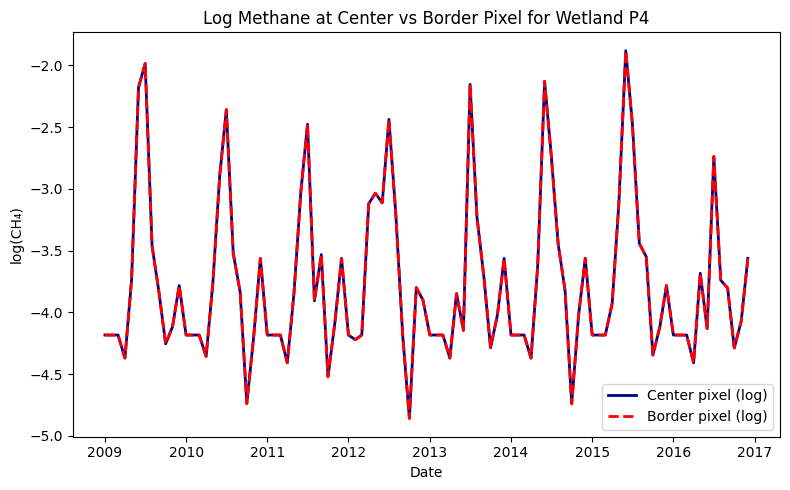

In [142]:
# ----- Center pixel time series -----
center_ts = df.merge(
    center_pixels_observed,
    on=[lat_col, lon_col, wetland_col],
    how="inner")

center_ts = center_ts[[date_col, wetland_col, pred_col]].rename(
    columns={pred_col: "log_center"}
)

# ----- Border pixel time series -----
border_ts = df.merge(
    border_pixels_observed,
    on=[lat_col, lon_col, wetland_col],
    how="inner")

border_ts = border_ts[[date_col, wetland_col, pred_col]].rename(
    columns={pred_col: "log_border"})

# Align center and border by (DATE, Wetland_ID)
center_border = center_ts.merge(
    border_ts,
    on=[date_col, wetland_col],
    how="inner"
)

# -----------------------------
# Stay in log units
# -----------------------------

# Log of the ratio center/border (optional but interpretable)
# log_ratio = log(center) - log(border) = log(center / border)
center_border["log_ratio_center_border"] = (
    center_border["log_center"] - center_border["log_border"]
)

# -----------------------------
# Plot: center vs border (log units)
# -----------------------------
import matplotlib.pyplot as plt

wet_id = "P4"  # change to any Wetland_ID you care about

sub = (
    center_border[center_border[wetland_col] == wet_id]
    .sort_values(date_col))

fig, ax = plt.subplots(figsize=(8, 5))

# Plot log methane values for center and border
ax.plot(sub[date_col], sub["log_center"], label="Center pixel (log)", linewidth=2, color='darkblue')
ax.plot(sub[date_col], sub["log_border"], label="Border pixel (log)", linewidth=2, linestyle="--", color='red')

ax.set_title(f"Log Methane at Center vs Border Pixel for Wetland {wet_id}")
ax.set_xlabel("Date")
ax.set_ylabel("log(CH₄)")  # natural log of methane

ax.legend()
plt.tight_layout()
plt.show()

In [138]:
center_ts[center_ts['Wetland_ID'] == 'P3']

,DATE,Wetland_ID,log_center
7,2009-01-01,P3,-4.979439
20,2009-02-01,P3,-4.979439
33,2009-03-01,P3,-4.979439
46,2009-04-01,P3,-4.246000
59,2009-05-01,P3,-4.088913
...,...,...,...
1190,2016-08-01,P3,-3.610203
1203,2016-09-01,P3,-3.554277
1216,2016-10-01,P3,-3.879346
1229,2016-11-01,P3,-3.556027


In [139]:
border_ts[border_ts['Wetland_ID'] == 'P3']

,DATE,Wetland_ID,log_border
7,2009-01-01,P3,-4.979439
20,2009-02-01,P3,-4.979439
33,2009-03-01,P3,-4.979439
46,2009-04-01,P3,-4.246000
59,2009-05-01,P3,-4.088913
...,...,...,...
1190,2016-08-01,P3,-3.610203
1203,2016-09-01,P3,-3.554277
1216,2016-10-01,P3,-3.879346
1229,2016-11-01,P3,-3.556027


In [119]:
center_border[center_border['log_ratio_center_border']>0]

,DATE,Wetland_ID,log_center,log_border,log_ratio_center_border
4,2009-01-01,P8,0.270253,-4.237288,4.507541
6,2009-01-01,T3,-4.469773,-4.500785,0.031012
17,2009-02-01,P8,0.270253,-4.237288,4.507541
19,2009-02-01,T3,-4.469773,-4.500785,0.031012
30,2009-03-01,P8,0.270253,-4.237288,4.507541
...,...,...,...,...,...
1200,2016-09-01,P8,4.677404,-3.048899,7.726303
1213,2016-10-01,P8,1.157301,-3.820610,4.977911
1226,2016-11-01,P8,-1.685752,-3.582368,1.896615
1239,2016-12-01,P8,-1.567438,-3.274867,1.707430


In [121]:
center_ts

,DATE,Wetland_ID,log_center
0,2009-01-01,P1,-4.196386
1,2009-01-01,P4,-4.183199
2,2009-01-01,P7,-4.237288
3,2009-01-01,P6,-4.237288
4,2009-01-01,P8,0.270253
...,...,...,...
1243,2016-12-01,T8,-3.254337
1244,2016-12-01,T2,-3.486088
1245,2016-12-01,T6,-4.132221
1246,2016-12-01,T7,-3.839596


In [122]:
border_ts

,DATE,Wetland_ID,log_border
0,2009-01-01,P1,-4.196386
1,2009-01-01,P4,-4.183199
2,2009-01-01,P7,-4.237288
3,2009-01-01,P6,-4.237288
4,2009-01-01,P8,-4.237288
...,...,...,...
1243,2016-12-01,T8,-3.254337
1244,2016-12-01,T2,-3.486088
1245,2016-12-01,T6,-4.132221
1246,2016-12-01,T7,-3.839596


In [140]:
df[(df['LAT'] == 47.09700846245007) & (df['LONG'] == -99.0989531253692)]['predictions']

1       -4.196386
618     -4.196386
1235    -4.196386
1852    -4.383106
2469    -3.871837
           ...   
56148   -3.771100
56765   -3.821180
57382   -4.315842
57999   -4.095138
58616   -3.486154
Name: predictions, Length: 96, dtype: float64

In [141]:
df[(df['LAT'] == 47.09700846214319) & (df['LONG'] == -99.0992226186754)]['predictions']

0       -4.196386
617     -4.196386
1234    -4.196386
1851    -4.383106
2468    -3.871837
           ...   
56147   -3.771100
56764   -3.821180
57381   -4.315842
57998   -4.095138
58615   -3.486154
Name: predictions, Length: 96, dtype: float64

In [130]:
border_pixels_observed.iloc[0, 5]

np.float64(47.09700846214319)

In [135]:
center_pixels_observed

,Wetland_ID,center_lat,center_lon,LAT_IN_DF,LONG_IN_DF
0,P1,47.098356,-99.098953,47.097008,-99.098953
3,P3,47.101590,-99.101918,47.101320,-99.101918
4,P4,47.101320,-99.094641,47.099973,-99.093833
5,P6,47.096739,-99.097067,47.095391,-99.097606
6,P7,47.095661,-99.100031,47.094583,-99.100840
7,P8,47.099164,-99.104343,47.098625,-99.104613
9,T2,47.097278,-99.104074,47.096739,-99.103804
10,T3,47.099164,-99.097067,47.098625,-99.097606
12,T5,47.098356,-99.094911,47.098356,-99.094641
13,T6,47.099434,-99.093833,47.099164,-99.093833


In [134]:
border_pixels_observed

,Wetland_ID,border_lat,border_lon,LAT_IN_DF,LONG_IN_DF
0,P1,47.099434,-99.101109,47.097008,-99.099223
3,P3,47.101051,-99.102187,47.101051,-99.102187
4,P4,47.102129,-99.092755,47.099973,-99.095180
5,P6,47.095391,-99.098145,47.095391,-99.098145
6,P7,47.096739,-99.098684,47.094583,-99.101109
7,P8,47.098086,-99.104882,47.098086,-99.104882
9,T2,47.096739,-99.103804,47.096739,-99.104074
10,T3,47.099434,-99.096258,47.098625,-99.097875
12,T5,47.098356,-99.095180,47.098086,-99.094911
13,T6,47.099164,-99.094372,47.099164,-99.094372


In [143]:
wet_centroids

,wet_cx,wet_cy
Wetland_ID,,
P1,492480.879276,5.216097e+06
P11,488894.078070,5.217322e+06
P2,492575.209411,5.216538e+06
P3,492256.146999,5.216469e+06
P4,492821.481717,5.216421e+06
P6,492624.050359,5.215925e+06
P7,492405.406596,5.215798e+06
P8,492079.472205,5.216181e+06
T1,492297.043102,5.216125e+06


In [145]:
center_pixels['LAT_IN_DF'] = np.nan
center_pixels['LONG_IN_DF'] = np.nan

latloc = center_pixels.columns.get_loc('LAT_IN_DF')
longloc = center_pixels.columns.get_loc('LONG_IN_DF')

for index, row in center_pixels.iterrows():
    min_distance_center = 1000000
    
    wetland = row['Wetland_ID']
    center_lat = row['center_lat']
    center_long = row['center_lon']

    df_subset = df[df['Wetland_ID'] == wetland]

    if df_subset.size == 0:
        continue

    lat_min_distance = 0
    long_min_distance = 0

    for index1, row in df_subset.iterrows():
        lat1 = row['LAT']
        long1 = row['LONG']

        euclidean_distance_center = np.sqrt((lat1 - center_lat)**2 + (long1 - center_long)**2)

        if euclidean_distance_center < min_distance_center:
            min_distance_center = euclidean_distance_center
            lat_min_distance = lat1
            long_min_distance = long1
            
    center_pixels.iloc[index, latloc] = lat_min_distance
    center_pixels.iloc[index, longloc] = long_min_distance


border_pixels['LAT_IN_DF'] = np.nan
border_pixels['LONG_IN_DF'] = np.nan

latloc = border_pixels.columns.get_loc('LAT_IN_DF')
longloc = border_pixels.columns.get_loc('LONG_IN_DF')

for index, row in border_pixels.iterrows():
    min_distance_border = 1000000
    
    wetland = row['Wetland_ID']
    border_lat = row['border_lat']
    border_long = row['border_lon']

    df_subset = df[df['Wetland_ID'] == wetland]

    if df_subset.size == 0:
        continue

    lat_min_distance = 0
    long_min_distance = 0

    for index1, row in df_subset.iterrows():
        lat1 = row['LAT']
        long1 = row['LONG']

        euclidean_distance_border = np.sqrt((lat1 - border_lat)**2 + (long1 - border_long)**2)

        if euclidean_distance_border < min_distance_border:
            min_distance_border = euclidean_distance_border
            lat_min_distance = lat1
            long_min_distance = long1
            
    border_pixels.iloc[index, latloc] = lat_min_distance
    border_pixels.iloc[index, longloc] = long_min_distance


center_pixels_observed = center_pixels[~center_pixels['LAT_IN_DF'].isna()]
border_pixels_observed = border_pixels[~border_pixels['LAT_IN_DF'].isna()]

center_pixels_observed['LAT'] = center_pixels_observed.loc[:, 'LAT_IN_DF']
center_pixels_observed['LONG'] = center_pixels_observed.loc[:, 'LONG_IN_DF']
border_pixels_observed['LAT'] = border_pixels_observed.loc[:, 'LAT_IN_DF']
border_pixels_observed['LONG'] = border_pixels_observed.loc[:, 'LONG_IN_DF']

/var/folders/zn/fbx3h9w10m1ff_g3y0gg08lw0000gq/T/ipykernel_78252/4118695408.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center_pixels_observed['LAT'] = center_pixels_observed.loc[:, 'LAT_IN_DF']
/var/folders/zn/fbx3h9w10m1ff_g3y0gg08lw0000gq/T/ipykernel_78252/4118695408.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center_pixels_observed['LONG'] = center_pixels_observed.loc[:, 'LONG_IN_DF']
/var/folders/zn/fbx3h9w10m1ff_g3y0gg08lw0000gq/T/ipykernel_78252/4118695408.py:78: SettingWithCopyWarn

In [153]:
center_pixels_observed

,Wetland_ID,center_lat,center_lon,LAT_IN_DF,LONG_IN_DF,LAT,LONG
0,P1,47.098356,-99.098953,47.098356,-99.098953,47.098356,-99.098953
3,P3,47.101590,-99.101918,47.101590,-99.101918,47.101590,-99.101918
4,P4,47.101320,-99.094641,47.101320,-99.094641,47.101320,-99.094641
5,P6,47.096739,-99.097067,47.096739,-99.097067,47.096739,-99.097067
6,P7,47.095661,-99.100031,47.095661,-99.100031,47.095661,-99.100031
7,P8,47.099164,-99.104343,47.099164,-99.104343,47.099164,-99.104343
9,T2,47.097278,-99.104074,47.097278,-99.104074,47.097278,-99.104074
10,T3,47.099164,-99.097067,47.099164,-99.097067,47.099164,-99.097067
12,T5,47.098356,-99.094911,47.098356,-99.094911,47.098356,-99.094911
13,T6,47.099434,-99.093833,47.099434,-99.093833,47.099434,-99.093833


In [154]:
border_pixels_observed

,Wetland_ID,border_lat,border_lon,LAT_IN_DF,LONG_IN_DF,LAT,LONG
0,P1,47.099434,-99.101109,47.099434,-99.101109,47.099434,-99.101109
3,P3,47.101051,-99.102187,47.101051,-99.102187,47.101051,-99.102187
4,P4,47.102129,-99.092755,47.102129,-99.092755,47.102129,-99.092755
5,P6,47.095391,-99.098145,47.095391,-99.098145,47.095391,-99.098145
6,P7,47.096739,-99.098684,47.096739,-99.098684,47.096739,-99.098684
7,P8,47.098086,-99.104882,47.098086,-99.104882,47.098086,-99.104882
9,T2,47.096739,-99.103804,47.096739,-99.103804,47.096739,-99.103804
10,T3,47.099434,-99.096258,47.099434,-99.096258,47.099434,-99.096258
12,T5,47.098356,-99.095180,47.098356,-99.095180,47.098356,-99.095180
13,T6,47.099164,-99.094372,47.099164,-99.094372,47.099164,-99.094372


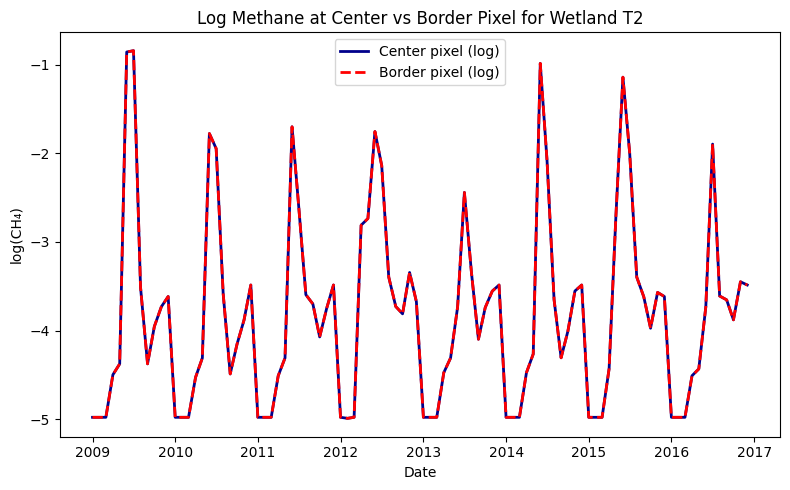

In [155]:
# ----- Center pixel time series -----
center_ts = df.merge(
    center_pixels_observed,
    on=[lat_col, lon_col, wetland_col],
    how="inner")

center_ts = center_ts[[date_col, wetland_col, pred_col]].rename(
    columns={pred_col: "log_center"}
)

# ----- Border pixel time series -----
border_ts = df.merge(
    border_pixels_observed,
    on=[lat_col, lon_col, wetland_col],
    how="inner")

border_ts = border_ts[[date_col, wetland_col, pred_col]].rename(
    columns={pred_col: "log_border"})

# Align center and border by (DATE, Wetland_ID)
center_border = center_ts.merge(
    border_ts,
    on=[date_col, wetland_col],
    how="inner"
)

# -----------------------------
# Stay in log units
# -----------------------------

# Log of the ratio center/border (optional but interpretable)
# log_ratio = log(center) - log(border) = log(center / border)
center_border["log_ratio_center_border"] = (
    center_border["log_center"] - center_border["log_border"]
)

# -----------------------------
# Plot: center vs border (log units)
# -----------------------------
import matplotlib.pyplot as plt

wet_id = "T2"  # change to any Wetland_ID you care about

sub = (
    center_border[center_border[wetland_col] == wet_id]
    .sort_values(date_col))

fig, ax = plt.subplots(figsize=(8, 5))

# Plot log methane values for center and border
ax.plot(sub[date_col], sub["log_center"], label="Center pixel (log)", linewidth=2, color='darkblue')
ax.plot(sub[date_col], sub["log_border"], label="Border pixel (log)", linewidth=2, linestyle="--", color='red')

ax.set_title(f"Log Methane at Center vs Border Pixel for Wetland {wet_id}")
ax.set_xlabel("Date")
ax.set_ylabel("log(CH₄)")  # natural log of methane

ax.legend()
plt.tight_layout()
plt.show()

In [178]:
wetland = 'T3'

center_lat = center_pixels_observed[center_pixels_observed['Wetland_ID'] == wetland]['LAT'].values[0]
center_long = center_pixels_observed[center_pixels_observed['Wetland_ID'] == wetland]['LONG'].values[0]
border_lat = border_pixels_observed[border_pixels_observed['Wetland_ID'] == wetland]['LAT'].values[0]
border_long = border_pixels_observed[border_pixels_observed['Wetland_ID'] == wetland]['LONG'].values[0]

center_pred_df = df[(df['Wetland_ID'] == wetland) &
    (df['LAT'] == center_lat) &
    (df['LONG'] == center_long)]

border_pred_df = df[(df['Wetland_ID'] == wetland) &
    (df['LAT'] == border_lat) &
    (df['LONG'] == border_long)]

In [179]:
center_pred_df

,CELL_AREA_M2,DATE,LAT,LONG,Wetland_ID,water,NO_DATA_IND,WATER_IND,HYDROPERIOD,MONTHS_NO_DATA,...,Month,Size_m2_fld,AIR_TMIN_C,AIR_TMAX_C,AIR_TEMP_AVG_C,Year,MEAN NDVI LAG,Hydroperiod_days_fld,NDVI_lag_rs,predictions
520,611.289438,2009-01-01,47.099164,-99.097067,T3,0,1,0,0.0,6.0,...,1,5500.0,-24.750000,-7.790000,-16.270,2009,0.034779,0.0,0.034779,-4.469773
1137,611.289438,2009-02-01,47.099164,-99.097067,T3,0,1,0,0.0,6.0,...,2,5500.0,-11.340000,-3.840000,-7.590,2009,0.034779,0.0,0.034779,-4.469773
1754,611.289438,2009-03-01,47.099164,-99.097067,T3,0,1,0,0.0,6.0,...,3,5500.0,-28.299999,-13.600000,-20.950,2009,0.034779,0.0,0.034779,-4.469773
2371,611.289438,2009-04-01,47.099164,-99.097067,T3,0,1,0,0.0,6.0,...,4,5500.0,-5.030000,-0.150000,-2.590,2009,0.123052,0.0,0.123052,-3.845474
2988,611.289438,2009-05-01,47.099164,-99.097067,T3,1,0,0,0.0,6.0,...,5,5500.0,-0.010000,13.060000,6.525,2009,0.121121,0.0,0.121121,-3.539794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56667,611.289438,2016-08-01,47.099164,-99.097067,T3,1,0,0,0.0,5.0,...,8,5500.0,18.370001,28.549999,23.460,2016,0.011424,0.0,0.011424,-3.512714
57284,611.289438,2016-09-01,47.099164,-99.097067,T3,1,0,0,0.0,5.0,...,9,5500.0,13.770000,28.410000,21.090,2016,0.392602,0.0,0.392602,-3.751481
57901,611.289438,2016-10-01,47.099164,-99.097067,T3,0,1,0,0.0,5.0,...,10,5500.0,9.920000,22.090000,16.005,2016,0.052801,0.0,0.052801,-3.747249
58518,611.289438,2016-11-01,47.099164,-99.097067,T3,0,1,0,0.0,5.0,...,11,5500.0,3.660000,12.760000,8.210,2016,0.221899,0.0,0.221899,-3.589880


In [180]:
border_pred_df

,CELL_AREA_M2,DATE,LAT,LONG,Wetland_ID,water,NO_DATA_IND,WATER_IND,HYDROPERIOD,MONTHS_NO_DATA,...,Month,Size_m2_fld,AIR_TMIN_C,AIR_TMAX_C,AIR_TEMP_AVG_C,Year,MEAN NDVI LAG,Hydroperiod_days_fld,NDVI_lag_rs,predictions
530,611.286344,2009-01-01,47.099434,-99.096258,T3,0,1,0,0.0,6.0,...,1,5500.0,-24.750000,-7.790000,-16.270,2009,0.034779,0.0,0.034779,-4.469773
1147,611.286344,2009-02-01,47.099434,-99.096258,T3,0,1,0,0.0,6.0,...,2,5500.0,-11.340000,-3.840000,-7.590,2009,0.034779,0.0,0.034779,-4.469773
1764,611.286344,2009-03-01,47.099434,-99.096258,T3,0,1,0,0.0,6.0,...,3,5500.0,-28.299999,-13.600000,-20.950,2009,0.034779,0.0,0.034779,-4.469773
2381,611.286344,2009-04-01,47.099434,-99.096258,T3,0,1,0,0.0,6.0,...,4,5500.0,-5.030000,-0.150000,-2.590,2009,0.123052,0.0,0.123052,-3.845474
2998,611.286344,2009-05-01,47.099434,-99.096258,T3,1,0,0,0.0,6.0,...,5,5500.0,-0.010000,13.060000,6.525,2009,0.121121,0.0,0.121121,-3.539794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56677,611.286344,2016-08-01,47.099434,-99.096258,T3,1,0,0,0.0,5.0,...,8,5500.0,18.370001,28.549999,23.460,2016,0.011424,0.0,0.011424,-3.512714
57294,611.286344,2016-09-01,47.099434,-99.096258,T3,1,0,0,0.0,5.0,...,9,5500.0,13.770000,28.410000,21.090,2016,0.392602,0.0,0.392602,-3.751481
57911,611.286344,2016-10-01,47.099434,-99.096258,T3,0,1,0,0.0,5.0,...,10,5500.0,9.920000,22.090000,16.005,2016,0.052801,0.0,0.052801,-3.747249
58528,611.286344,2016-11-01,47.099434,-99.096258,T3,0,1,0,0.0,5.0,...,11,5500.0,3.660000,12.760000,8.210,2016,0.221899,0.0,0.221899,-3.589880


In [165]:
df

,CELL_AREA_M2,DATE,LAT,LONG,Wetland_ID,water,NO_DATA_IND,WATER_IND,HYDROPERIOD,MONTHS_NO_DATA,...,Month,Size_m2_fld,AIR_TMIN_C,AIR_TMAX_C,AIR_TEMP_AVG_C,Year,MEAN NDVI LAG,Hydroperiod_days_fld,NDVI_lag_rs,predictions
0,611.314190,2009-01-01,47.097008,-99.099223,P1,0,1,0,0.0,6.0,...,1,58200.0,-24.739542,-7.779542,-16.259542,2009,-0.082529,0.0,-0.082529,-4.196386
1,611.314190,2009-01-01,47.097008,-99.098953,P1,0,1,0,0.0,6.0,...,1,58200.0,-24.739542,-7.779542,-16.259542,2009,-0.082529,0.0,-0.082529,-4.196386
2,611.314190,2009-01-01,47.097008,-99.098684,P1,0,1,0,0.0,6.0,...,1,58200.0,-24.739542,-7.779542,-16.259542,2009,-0.082529,0.0,-0.082529,-4.196386
3,611.314190,2009-01-01,47.097008,-99.098414,P1,0,1,0,0.0,6.0,...,1,58200.0,-24.739542,-7.779542,-16.259542,2009,-0.082529,0.0,-0.082529,-4.196386
4,611.311096,2009-01-01,47.097278,-99.100301,P1,0,1,0,0.0,6.0,...,1,58200.0,-24.739542,-7.779542,-16.259542,2009,-0.082529,0.0,-0.082529,-4.196386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59227,611.301814,2016-12-01,47.098086,-99.094911,T5,0,1,0,0.0,5.0,...,12,2300.0,-3.690000,-2.000000,-2.845000,2016,0.164063,0.0,0.164063,-3.839577
59228,611.301814,2016-12-01,47.098086,-99.094641,T5,0,1,0,0.0,5.0,...,12,2300.0,-3.690000,-2.000000,-2.845000,2016,0.164063,0.0,0.164063,-3.839577
59229,611.298721,2016-12-01,47.098356,-99.095180,T5,0,1,0,0.0,5.0,...,12,2300.0,-3.690000,-2.000000,-2.845000,2016,0.164063,0.0,0.164063,-3.839577
59230,611.298721,2016-12-01,47.098356,-99.094911,T5,0,1,0,0.0,5.0,...,12,2300.0,-3.690000,-2.000000,-2.845000,2016,0.164063,0.0,0.164063,-3.839577


In [181]:
df[(df['Wetland_ID'] == 'T3') & (df['HYDROPERIOD'] > 0)]

,CELL_AREA_M2,DATE,LAT,LONG,Wetland_ID,water,NO_DATA_IND,WATER_IND,HYDROPERIOD,MONTHS_NO_DATA,...,Month,Size_m2_fld,AIR_TMIN_C,AIR_TMAX_C,AIR_TEMP_AVG_C,Year,MEAN NDVI LAG,Hydroperiod_days_fld,NDVI_lag_rs,predictions
504,611.295626,2009-01-01,47.098625,-99.097875,T3,0,1,0,91.5,7.0,...,1,5500.0,-24.750000,-7.790000,-16.270,2009,0.034779,91.5,0.034779,-4.500785
1121,611.295626,2009-02-01,47.098625,-99.097875,T3,0,1,0,91.5,7.0,...,2,5500.0,-11.340000,-3.840000,-7.590,2009,0.034779,91.5,0.034779,-4.500785
1738,611.295626,2009-03-01,47.098625,-99.097875,T3,0,1,0,91.5,7.0,...,3,5500.0,-28.299999,-13.600000,-20.950,2009,0.034779,91.5,0.034779,-4.500785
2355,611.295626,2009-04-01,47.098625,-99.097875,T3,0,1,0,91.5,7.0,...,4,5500.0,-5.030000,-0.150000,-2.590,2009,0.123052,91.5,0.123052,-4.337323
2972,611.295626,2009-05-01,47.098625,-99.097875,T3,2,0,1,91.5,7.0,...,5,5500.0,-0.010000,13.060000,6.525,2009,0.121121,91.5,0.121121,-4.526139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56651,611.295626,2016-08-01,47.098625,-99.097875,T3,1,0,0,152.5,5.0,...,8,5500.0,18.370001,28.549999,23.460,2016,0.011424,152.5,0.011424,0.002749
57268,611.295626,2016-09-01,47.098625,-99.097875,T3,2,0,1,152.5,5.0,...,9,5500.0,13.770000,28.410000,21.090,2016,0.392602,152.5,0.392602,-2.085334
57885,611.295626,2016-10-01,47.098625,-99.097875,T3,0,1,0,152.5,5.0,...,10,5500.0,9.920000,22.090000,16.005,2016,0.052801,152.5,0.052801,-1.779977
58502,611.295626,2016-11-01,47.098625,-99.097875,T3,0,1,0,152.5,5.0,...,11,5500.0,3.660000,12.760000,8.210,2016,0.221899,152.5,0.221899,-2.306035
